# Accuinsight+ Modeler AutoDL tutorial
## 비정상 거래를 탐지하는 Autoencoder 모델
## 목차
1. [분석 개요](#AE_분석_개요)
2. [데이터](#AE_데이터)
3. [Autoencoder 모델 구성 및 학습](#AE_모델_구성_및_학습)
4. [Autoencoder의 latent feature를 추출, logistic regression을 통해 분류](#logistic_regression_분류)
5. [분류 결과 시각화](#분류_결과_시각화)
6. [AutoDL 사용방법](#AutoDL_사용방법)

<a id='AE_분석_개요'></a>
## 분석 개요
- kaggle에서 제공하는 [신용카드 거래 데이터](https://www.kaggle.com/mlg-ulb/creditcardfraud)를 사용해 정상 거래와 비정상 거래를 분류하는 예제입니다.
- __정상 거래 데이터만으로 학습한 Autoencoder 모델__에 데이터를 입력했을 때  
  정상 데이터와 비정상 데이터를 각기 다르게 복원하게 하는 특성을 이용하여 이상 거래를 탐지합니다.
<p align="center">
    <img src="pic/autoencoder.png" height="600px" width="700px">
</p>

In [26]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime, timezone

import tensorflow as tf
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model, Sequential

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing 
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import easydict

<a id='AE_데이터'></a>
## 데이터
- 거래 건당 30개의 feature(PCA 기법으로 원본 데이터를 차원 축소한 28개의 feature, 시간, 금액)와 label이 주어집니다.
- 비정상 거래보다 정상 거래 건수가 압도적으로 많은 __불균형 데이터__입니다.

In [27]:
data_path = 'data/creditcard.csv'
data = pd.read_csv(data_path)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### 불균형 데이터
- 비정상 거래 492건, 정상 거래 284,807건으로 구성된 불균형 데이터입니다.

In [28]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index": "Target", "Class": "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


#### 정상 데이터의 90%를 train dataset으로 사용하고, 정상 데이터의 10%와 비정상 데이터를 합쳐 test dataset으로 사용합니다.  
- train dataset: 255,883건  
- test dataset: 28,924건 (정상: 28,432건 / 비정상: 492건) 
- train dataset은 Autoencoder 모델을 학습하기 위해 사용되고  
  test dataset은 학습된 Autoencoder 모델에 입력하여 latent feature를 추출한 다음, logistic regression 모델로 분류하기 위해 사용됩니다.

In [29]:
norm = data[data.Class==0]
fraud = data[data.Class==1]

In [30]:
train, test = np.split(norm, [int(.9*len(norm))])

In [31]:
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [32]:
test.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
256353,157653.0,0.731816,0.543392,-0.085945,1.268660,-0.159982,-0.619255,0.283256,-0.108726,0.169950,...,-0.193578,-0.480363,0.168863,-0.115903,-0.827009,0.651625,-0.154819,-0.065644,1.00,0
256354,157653.0,-0.242040,1.549146,1.476833,4.339271,0.308702,1.414228,-0.188777,0.404470,-1.567373,...,0.293116,1.059992,-0.097677,0.523527,-0.891785,0.329422,-0.133825,-0.058125,0.76,0
256355,157654.0,2.028646,0.390124,-2.510975,1.269100,1.164603,-0.417938,0.460250,-0.080407,0.099964,...,-0.035499,0.019330,-0.037168,0.060008,0.466886,-0.506979,-0.013261,-0.040753,1.91,0
256356,157654.0,2.144150,0.032373,-2.480387,-0.305776,1.014616,-0.736587,0.616030,-0.316019,0.038975,...,0.147318,0.482183,-0.092222,0.137528,0.498099,0.227612,-0.098398,-0.089266,3.78,0
256357,157654.0,-0.139570,0.986571,-0.352421,-0.623365,0.618640,-0.691550,0.879960,-0.040333,0.105570,...,0.362065,1.302968,-0.156491,-0.390288,-0.779148,-0.205793,0.608550,0.365623,4.49,0


In [33]:
fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [34]:
print("train:", len(train), "test:", len(test))
print("total:", len(train)+len(test))

train: 255883 test: 28432
total: 284315


In [35]:
total_test = pd.concat([test, fraud]).sample(frac=1).reset_index(drop=True)

In [36]:
train.to_csv("data/creditcard_train.csv", mode='w', index=False)
total_test.to_csv("data/creditcard_test.csv", mode='w', index=False)

In [37]:
total_data_path = 'data/creditcard.csv'
train_data_path = "data/creditcard_train.csv"
test_data_path = "data/creditcard_test.csv"

In [38]:
train = pd.read_csv(train_data_path)
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<a id='AE_모델_구성_및_학습'></a>
## Autoencoder 모델 구성 및 학습
- 이번 예제에서 최적화할 하이퍼파라미터는 아래와 같습니다.
  - `batch_size`: 모델 학습의 반복 한 회당 사용되는 샘플의 개수
  - `learning_rate`: 경사하강법을 통해 모델을 학습시키는 데 사용되는 스칼라값으로, 각 반복에서 경사에 곱해지는 값
  - `num_nodes`: hidden layer의 노드 개수
  - `l2_penalty`: 과적합을 막기 위해 사용되는 L2 regularization의 $\lambda$ 값으로, 0에 가까울 수록 regularization의 효과가 없어짐  
- AutoDL을 사용하기 위해서는 __argparse__를 통해 하이퍼파라미터를 설정해야 하는데,  
  jupyter notebook에서는 argparse 사용이 불가능하기 때문에 __easydict__를 통해 하이퍼파라미터를 설정합니다.  
  실제로 AutoDL에 사용되는 [autodl_autoencoder_fraud_detection.py](autodl_autoencoder_fraud_detection.py)에서는 argparse를 통해 하이퍼파라미터를 설정합니다.

In [14]:
args = easydict.EasyDict({
    "epochs": 20,
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_nodes": 50,
    "l2_penalty": 0.01})

train dataset을 불러옵니다.

In [39]:
feature = np.zeros((255883, 30))
label = np.zeros((255883, 1))
with open(train_data_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for i, row in enumerate(reader):
        label[i, :] = int(row[-1])
        feature[i, :] = row[:30]

#### Autoencoder 모델 구성
- 하이퍼파라미터로 설정된 `num_nodes`에 따라 모델 구조가 달라집니다.

In [40]:
input_layer = Input(shape=(feature.shape[1],))

## encoding part
encoded = Dense(args.num_nodes,
                activation='relu',
                activity_regularizer=tf.keras.regularizers.l2(args.l2_penalty))(input_layer)
encoded = Dense(args.num_nodes/2, activation='relu')(encoded)

## decoding part
decoded = Dense(args.num_nodes/2, activation='relu')(encoded)
decoded = Dense(args.num_nodes, activation='relu')(decoded)

## output layer
output_layer = Dense(feature.shape[1], activation='relu')(decoded)

model = Model(input_layer, output_layer)

decay_rate = args.learning_rate / args.epochs
adam = tf.keras.optimizers.Adam(learning_rate=args.learning_rate, decay=decay_rate)
model.compile(optimizer=adam, loss="mse")

feature_scale = preprocessing.MinMaxScaler().fit_transform(feature)

<a id='평가지표_출력'></a>
#### 평가지표 출력
- AutoDL에서 평가 지표를 수집할 수 있도록 epoch이 종료될 때마다 평가 지표(Loss)를 출력합니다.
- 이번 예제에서는 __평가 지표명=평가 지표값__ 형식으로 평가 지표를 출력하는데,  
  평가 지표 설정 방법은 [Modeler AutoDL 사용방법](#평가지표_수집) 챕터에서 좀 더 자세히 다룰 것입니다.

In [41]:
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch {}".format(epoch + 1))
        print("Train-loss={:.4f}".format(logs['loss']))
        print("Validation-loss={:.4f}".format(logs['val_loss']))
        
history = MetricHistory()

#### Autoencoder 모델 학습  
- Autoencoder 모델의 input과 output은 모두 `feature_scale`(min-max scaling을 거친 feature)입니다.
- Autoencoder 모델의 학습 목표는 데이터를 최대한 정확하게 복원하는 것, 즉 input과 output 사이의 __reconstruction error를 최소화__하는 것입니다.  
- __정상 데이터만을 학습__하여 정상 데이터를 최대한 정확하게 복원하도록 학습합니다.

In [18]:
model.fit(feature_scale,
          feature_scale,
          batch_size = args.batch_size,
          epochs = args.epochs,
          shuffle = True,
          validation_split = 0.2,
          callbacks = history)

Epoch 1/20
6360/6398 [============================>.] - ETA: 0s - loss: 0.1279- ET
Epoch 1
Train-loss=0.1277
Validation-loss=0.1027
6398/6398 [==============================] - 8s 1ms/step - loss: 0.1277 - val_loss: 0.1027
Epoch 2/20
6356/6398 [============================>.] - ETA: 0s - loss: 0.1022
Epoch 2
Train-loss=0.1022
Validation-loss=0.1024
6398/6398 [==============================] - 8s 1ms/step - loss: 0.1022 - val_loss: 0.1024
Epoch 3/20
6356/6398 [============================>.] - ETA: 0s - loss: 0.1019- ETA: 
Epoch 3
Train-loss=0.1019
Validation-loss=0.1022
6398/6398 [==============================] - 8s 1ms/step - loss: 0.1019 - val_loss: 0.1022
Epoch 4/20
6371/6398 [============================>.] - ETA: 0s - loss: 0.0844- ETA: 0s - loss:
Epoch 4
Train-loss=0.0844
Validation-loss=0.0810
6398/6398 [==============================] - 8s 1ms/step - loss: 0.0844 - val_loss: 0.0810
Epoch 5/20
6392/6398 [============================>.] - ETA: 0s - loss: 0.0807
Epoch 5
Train-los

<a id='logistic_regression_분류'></a>
## Autoencoder의 latent feature를 추출, logistic regression을 통해 분류 

In [19]:
data = pd.read_csv(test_data_path)
norm = data[data.Class==0]
fraud = data[data.Class==1]

x_norm = norm.drop(['Class'], axis = 1).values
x_fraud = fraud.drop(['Class'], axis = 1).values

Autoencoder 모델의 중간 layer에서 latent feature `norm_latent_feature`, `fraud_latent_feature`를 추출합니다.

In [20]:
hidden_representation = Sequential()
hidden_representation.add(model.layers[0])
hidden_representation.add(model.layers[1])
hidden_representation.add(model.layers[2])

# min-max scaling
x_norm_scale = preprocessing.MinMaxScaler().fit_transform(x_norm)
x_fraud_scale = preprocessing.MinMaxScaler().fit_transform(x_fraud)

# Autoencoder 모델의 중간 layer에서 latent featrue 추출
norm_latent_feature = hidden_representation.predict(x_norm_scale)
fraud_latent_feature = hidden_representation.predict(x_fraud_scale)

rep_x = np.append(norm_latent_feature, fraud_latent_feature, axis = 0)
y_n = np.zeros(norm_latent_feature.shape[0])
y_f = np.ones(fraud_latent_feature.shape[0])
rep_y = np.append(y_n, y_f)

<a id='튜닝_전_결과'></a>
#### logistic regression 모델로 정상, 비정상 데이터를 분류
- logistic regression 모델에 latent feature를 입력하여 분류한 결과,  
  정상 거래를 비정상 거래로 오분류한 경우는 2건, 비정상 거래를 정상 거래로 오분류한 경우는 33건입니다.
- [Modeler AutoDL 사용방법](#AutoDL_사용방법) 챕터에서 AutoDL 기능으로 Autoencoder 모델의 하이퍼파라미터를 튜닝하여 오분류 샘플의 개수를 줄이는 과정을 살펴볼 것입니다.

In [22]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

matrix = confusion_matrix(val_y, pred_y)
print(matrix)


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7111
         1.0       0.98      0.72      0.83       120

    accuracy                           1.00      7231
   macro avg       0.99      0.86      0.92      7231
weighted avg       1.00      1.00      0.99      7231

[[7109    2]
 [  33   87]]


<a id='분류_결과_시각화'></a>
## 분류 결과 시각화  
- 정상 데이터 중 3000개를 샘플링한 데이터와 비정상 데이터의 latent feature를 시각화합니다.
- 시각화에는 고차원 데이터를 저차원으로 축소해 시각화하는데 유용하게 사용되는 __t-SNE__ 기법을 사용합니다.
- 몇 개의 샘플을 제외하고, Autoencoder에서 추출한 정상 데이터와 비정상 데이터의 latent feature가 명확하게 구분되는 것을 확인할 수 있습니다.

In [23]:
rep_x = np.append(norm_latent_feature[:3000], fraud_latent_feature, axis = 0)
y_n = np.zeros(norm_latent_feature[:3000].shape[0])
y_f = np.ones(fraud_latent_feature.shape[0])
rep_y = np.append(y_n, y_f)

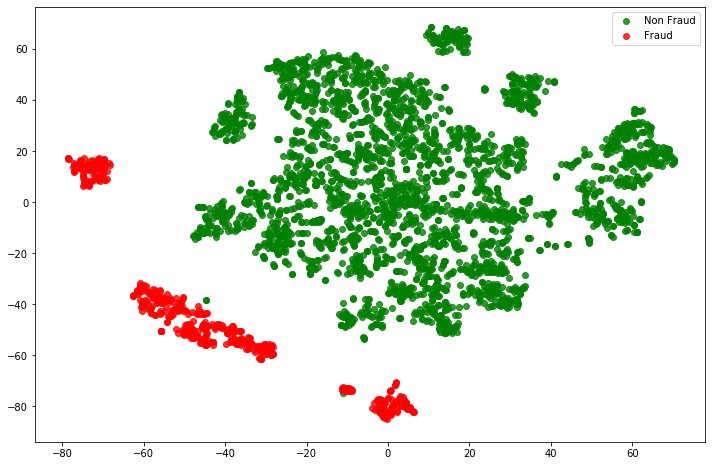

In [24]:
tsne = TSNE(n_components=2, random_state=1)
X_t = tsne.fit_transform(rep_x)

plt.figure(figsize=(12, 8))
plt.scatter(X_t[np.where(rep_y == 0), 0], X_t[np.where(rep_y == 0), 1], marker='o', color='g', linewidth=1, alpha=0.8, label='Non Fraud')
plt.scatter(X_t[np.where(rep_y == 1), 0], X_t[np.where(rep_y == 1), 1], marker='o', color='r', linewidth=1, alpha=0.8, label='Fraud')

plt.legend(loc='best')
plt.show()

<a id='AutoDL_사용방법'></a>
## Modeler AutoDL 사용방법
- 지금까지 부정 거래를 탐지하는 Autoencoder 모델 예제를 살펴보았습니다.
- 이번 챕터에서는 AutoDL 기능을 사용해 위에서 살펴본 Autoencoder 모델의 하이퍼파라미터를 최적화하는 과정에 대해 다룰 것입니다.

#### 1. jupyter lab
- 먼저 autodl에서 하이퍼파라미터 튜닝을 수행할 파이썬 모델 파일을 작성합니다. 본 예제에서는 [autodl_autoencoder_fraud_detection.py](autodl_autoencoder_fraud_detection.py)을 사용합니다.
- 파이썬 모델 실행에 필요한 데이터들은 __filestorage__ 폴더에 업로드합니다.

<p align="center">
    <img src="pic/1_jupyter_lab.png" height="1000px" width="1200px">
</p>

#### 2. docker 이미지 빌드
- jupyter lab에서 작성한 파이썬 모델, filestorage의 데이터와 워크스페이스에 설치된 라이브러리를 포함한 docker 이미지를 빌드하는 단계입니다.
- Modeler > 관리 > AutoDL > 모델관리부 > 이미지 탭에서 우측 상단의 __[이미지 추가]__ 버튼을 클릭합니다.
- 이미지명, 파이썬 모델링에 사용된 딥러닝 프레임워크, 워크스페이스의 파이썬 모델 파일과 이미지 설명을 입력하고 __[빌드]__ 버튼을 클릭합니다.
- 이미지는 __BUILDING__ > __UPLOADING__ > __COMPLETE__ 순서로 빌딩됩니다.

<p align="center">
    <img src="pic/2_add_image.png" height="1000px" width="1200px">
</p>
<p align="center">
    <img src="pic/3_image_list.png" height="1000px" width="1200px">
</p>

<a id='trialtemplate_생성'></a>
#### 3. trialtemplate 생성
- autodl 실행에 필요한 trialtemplate을 생성하는 단계입니다. trialtemplate은 docker image 빌드와 동시에 자동으로 생성됩니다.
- Modeler > 관리 > AutoDL > 모델관리부 > Trial Template 탭에서 자동 생성된 trialtemplate을 확인할 수 있습니다.
- 이 단계에서 사용자는 사용할 자원의 양만 수정하면 됩니다.

<p align="center">
    <img src="pic/4_trialtemplate.png" height="1000px" width="1200px">
</p>

<a id='평가지표_수집'></a>
#### 4. AutoDL yaml 작성 및 experiment 실행
- 마지막으로, 하이퍼파라미터 튜닝에 사용되는 옵션들을 설정하는 yaml을 작성하여 AutoDL experiment를 실행해 보겠습니다.
- 옵션 관련 자세한 사항은 [상세 매뉴얼](https://accuinsight.github.io/docs/modeler/management/autodl/)에서 확인하실 수 있습니다.
- __Metrics Collector__  
  - Autoencoder 모델 구성 및 학습 챕터에서 설정한 [평가 지표의 출력 형식](#평가지표_출력)과 관련된 옵션입니다.  
  - 출력된 평가 지표를 어떻게 수집할 것인지 설정합니다.
  - __StdOut__ 옵션은 metricsFormat에서 정의한 정규 표현식에 맞추어 평가 지표를 수집합니다.  
    metricsFormat의 디폴트 값인 ([\w|-]+)\s=\s((-?\d+)(.\d+)?)을 사용하면 __평가 지표명=평가 지표값__ 형식으로 출력된 평가 지표를 수집할 수 있습니다.
- __Algorithm__
  - 하이퍼파라미터 튜닝 알고리즘으로 __random__ 알고리즘을 선택합니다.
- __TrialCount__
  - AutoDL에서 trial은 하나의 하이퍼파라미터 조합을 적용해서 모델 성능을 평가하는 것을 의미합니다.    
    예를 들어, ParallelTrialCount=3이고 MaxTrialCount=12이면 3개의 trial을 동시에 실행하는 과정을 4번 반복하여 총 12개의 trial을 실행합니다.  
  - 본 예제에서는 trial을 1개씩 실행하여 총 20개의 trial을 실행하고 그 결과를 비교해 보겠습니다.

<p align="center">
    <img src="pic/5_1_autodl_yaml.png" height="1000px" width="1200px">
</p>

- Parameters에서 하이퍼파라미터의 타입과 탐색 범위를 지정합니다.
  - [Autoencoder 모델 구성 및 학습](#AE_모델_구성_및_학습) 챕터에서 설정한 하이퍼파라미터의 타입과 탐색 범위를 지정하는 단계입니다.
  - __int__, __double__: 하이퍼파라미터의 탐색 범위를 구간(FeasibleSpace)으로 지정합니다.
  - __categorical__: 하이퍼파라미터의 탐색 범위를 범주형 데이터(List)로 지정합니다.

<p align="center">
    <img src="pic/5_2_autodl_yaml.png" height="1000px" width="1200px">
</p>

- Objective에서 평가 지표를 설정합니다.  
  - 본 예제의 평가 지표는 Validation-loss이고, loss 값은 작아지도록 학습하는 것이 목표이므로 Type으로 minimize를 선택합니다.    
  - Goal에 도달하는 순간 AutoDL experiment가 종료됩니다.  
- Trial Spec에서 trialtemplate을 선택합니다.
  - [3. trialtemplate 생성](#trialtemplate_생성)에서 생성한 autodl-ae default.yaml을 선택합니다.  
- yaml 작성을 완료하면 __[생성]__ 버튼을 눌러 AutoDL experiment를 실행합니다.  
<p align="center">
    <img src="pic/5_3_autodl_yaml.png" height="1000px" width="1200px">
</p>

#### 5. 하이퍼파라미터 튜닝 결과
- 하이퍼파라미터 튜닝 결과를 확인합니다. autodl yaml에서 설정한 MaxTrialCount(20)만큼의 하이퍼파라미터 조합을 실험한 결과입니다.

<p align="center">
    <img src="pic/6_result.png" height="1000px" width="1200px">
</p>

#### 6. 최적 하이퍼파라미터 조합으로 모델을 재학습한 결과
- AutoDL experiment 실행 결과, 최적 하이퍼파라미터 조합은 아래와 같습니다.
  - batch_size = 37
  - learning_rate = 0.001
  - num_nodes = 50
  - l2_penalty = 0.0001

In [46]:
args = easydict.EasyDict({
    "epochs": 20,
    "batch_size": 37,
    "learning_rate": 0.001,
    "num_nodes": 50,
    "l2_penalty": 0.0001})

input_layer = Input(shape=(feature.shape[1],))

## encoding part
encoded = Dense(args.num_nodes,
                activation='relu',
                activity_regularizer=tf.keras.regularizers.l2(args.l2_penalty))(input_layer)
encoded = Dense(args.num_nodes/2, activation='relu')(encoded)

## decoding part
decoded = Dense(args.num_nodes/2, activation='relu')(encoded)
decoded = Dense(args.num_nodes, activation='relu')(decoded)

## output layer
output_layer = Dense(feature.shape[1], activation='relu')(decoded)

model = Model(input_layer, output_layer)

decay_rate = args.learning_rate / args.epochs
adam = tf.keras.optimizers.Adam(learning_rate=args.learning_rate, decay=decay_rate)
model.compile(optimizer=adam, loss="mse")

feature_scale = preprocessing.MinMaxScaler().fit_transform(feature)

model.fit(feature_scale,
          feature_scale,
          batch_size = args.batch_size,
          epochs = args.epochs,
          shuffle = True,
          validation_split = 0.2,
          callbacks = history)

Epoch 1/20
5494/5533 [============================>.] - ETA: 0s - loss: 0.0873
Epoch 1
Train-loss=0.0871
Validation-loss=0.0562
5533/5533 [==============================] - 7s 1ms/step - loss: 0.0871 - val_loss: 0.0562
Epoch 2/20
5502/5533 [============================>.] - ETA: 0s - loss: 0.0563
Epoch 2
Train-loss=0.0563
Validation-loss=0.0561
5533/5533 [==============================] - 7s 1ms/step - loss: 0.0563 - val_loss: 0.0561
Epoch 3/20
5519/5533 [============================>.] - ETA: 0s - loss: 0.0382
Epoch 3
Train-loss=0.0382
Validation-loss=0.0380
5533/5533 [==============================] - 7s 1ms/step - loss: 0.0382 - val_loss: 0.0380
Epoch 4/20
5533/5533 [==============================] - ETA: 0s - loss: 0.0235
Epoch 4
Train-loss=0.0235
Validation-loss=0.0239
5533/5533 [==============================] - 7s 1ms/step - loss: 0.0235 - val_loss: 0.0239
Epoch 5/20
5532/5533 [============================>.] - ETA: 0s - loss: 0.0232
Epoch 5
Train-loss=0.0232
Validation-loss=0.0

In [48]:
data = pd.read_csv(test_data_path)
norm = data[data.Class==0]
fraud = data[data.Class==1]

x_norm = norm.drop(['Class'], axis = 1).values
x_fraud = fraud.drop(['Class'], axis = 1).values

hidden_representation = Sequential()
hidden_representation.add(model.layers[0])
hidden_representation.add(model.layers[1])
hidden_representation.add(model.layers[2])

x_norm_scale = preprocessing.MinMaxScaler().fit_transform(x_norm)
x_fraud_scale = preprocessing.MinMaxScaler().fit_transform(x_fraud)
norm_latent_feature = hidden_representation.predict(x_norm_scale)
fraud_latent_feature = hidden_representation.predict(x_fraud_scale)

rep_x = np.append(norm_latent_feature, fraud_latent_feature, axis = 0)
y_n = np.zeros(norm_latent_feature.shape[0])
y_f = np.ones(fraud_latent_feature.shape[0])
rep_y = np.append(y_n, y_f)

- 최적 하이퍼파라미터 조합으로 Autoencoder 모델을 재학습한 결과,  
  정상 거래를 비정상 거래로 오분류한 경우는 2건, 비정상 거래를 정상 거래로 오분류한 경우는 9건입니다.
- [하이퍼파라미터 튜닝 전](#튜닝_전_결과)과 비교하여 비정상 거래를 정상 거래로 오분류하는 경우가 __33건__에서 __9건__으로 크게 줄어든 것을 확인할 수 있습니다.

In [47]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25, random_state=42)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

matrix = confusion_matrix(val_y, pred_y)
print(matrix)


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      7111
         1.0       0.98      0.93      0.95       120

    accuracy                           1.00      7231
   macro avg       0.99      0.96      0.98      7231
weighted avg       1.00      1.00      1.00      7231

[[7109    2]
 [   9  111]]
